## Training pipeline (RTM-generated dataset)

This notebook contains all the code used to train the NN with the RTM-generated dataset.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import layers
import keras_tuner as kt
import optuna
from datetime import datetime

### Dataset gathering

First the dataset is loaded:

In [3]:
dataset = pd.read_csv('../datasets/processed_calcite.csv')

In [5]:
dataset.describe()

,Unnamed: 0,Time,NodeID,mineralVolume_coupling,Ca_tr,H_tr,O_tr,Si_tr,charge_tr,C_tr,...,Cal,d_Jennite,Portlandite,t_Si,si_Cal,t_O,si_Amor-Sl,Amor-Sl,pe,water
count,750358.000000,7.503580e+05,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,...,750358.000000,7.503580e+05,750358.000000,750358.000000,7.503580e+05,750358.000000,750358.000000,750358.0,750358.000000,750358.000000
mean,375178.500000,1.060617e+10,538.811038,0.132986,0.018236,0.036401,0.036567,0.000049,-0.000034,0.000008,...,1.342483,-1.035605e-04,0.578148,0.000049,-2.233986e-15,0.036569,-5.833632,0.0,6.061015,100.000015
std,216609.840982,6.325040e+09,311.497978,0.022829,0.002961,0.005971,0.005902,0.000026,0.000007,0.000007,...,0.652024,2.058036e-03,0.413167,0.000026,2.389536e-13,0.005904,0.356560,0.0,0.910318,0.000057
min,0.000000,0.000000e+00,0.000000,0.108107,0.006771,0.013209,0.013780,0.000025,-0.000045,0.000006,...,1.184753,-6.146920e-02,0.000000,0.000025,-4.260947e-11,0.013780,-6.462203,0.0,-7.900199,99.999985
25%,187589.250000,5.108832e+09,269.000000,0.119833,0.017956,0.035843,0.036018,0.000039,-0.000040,0.000007,...,1.185400,2.302169e-08,0.000000,0.000039,0.000000e+00,0.035973,-5.989090,0.0,6.095166,100.000000
50%,375178.500000,1.059610e+10,539.000000,0.137282,0.019340,0.038631,0.038767,0.000039,-0.000037,0.000007,...,1.185403,1.052897e-06,0.890000,0.000039,0.000000e+00,0.038767,-5.969648,0.0,6.105869,100.000000
75%,562767.750000,1.608336e+10,809.000000,0.137284,0.019558,0.039065,0.039200,0.000045,-0.000029,0.000007,...,1.186351,2.611348e-05,0.890000,0.000045,0.000000e+00,0.039200,-5.838368,0.0,6.129809,100.000000
max,750357.000000,2.157062e+10,1078.000000,0.366590,0.025731,0.051439,0.051532,0.000199,-0.000011,0.000097,...,8.778986,5.871791e-04,0.890000,0.000199,4.209966e-13,0.051532,-4.175625,0.0,6.486472,100.000587


In [8]:
dataset.columns

Index(['Unnamed: 0', 'Time', 'Domain', 'NodeID', 'mineralVolume_coupling',
       'Ca_tr', 'H_tr', 'O_tr', 'Si_tr', 'charge_tr', 'C_tr', 'waterMass',
       'si_Portlandite', 't_C', 't_H', 'H2O', 'Jennite', 'd_Tob-II',
       'mineralVolume', 'Tob-II', 'd_Portlandite', 'd_Amor-Sl', 't_Ca', 'pH',
       'waterMassFraction', 'si_Tob-II', 'd_Cal', 'si_Jennite', 'Cal',
       'd_Jennite', 'Portlandite', 't_Si', 'si_Cal', 't_O', 'si_Amor-Sl',
       'Amor-Sl', 'pe', 'water'],
      dtype='object')

Then it is separated in input and output datasets.

In [9]:
input_dataset = dataset[['C_tr', 'Ca_tr','Si_tr','H_tr','O_tr', 'Cal','Portlandite', 'Jennite', 'waterMassFraction']]#.head(35000)
output_dataset = dataset[['t_C', 't_Ca','t_Si','t_H','t_O', 'd_Cal', 'd_Portlandite', 'd_Jennite', 'water']]#.head(35000)

In [15]:
input_dataset.columns

Index(['C_tr', 'Ca_tr', 'Si_tr', 'H_tr', 'O_tr', 'Cal', 'Portlandite',
       'Jennite', 'waterMassFraction'],
      dtype='object')

In [14]:
output_dataset.columns

Index(['t_C', 't_Ca', 't_Si', 't_H', 't_O', 'd_Cal', 'd_Portlandite',
       'd_Jennite', 'water'],
      dtype='object')

In [17]:
output_dataset.describe()

,t_C,t_Ca,t_Si,t_H,t_O,d_Cal,d_Portlandite,d_Jennite,water
count,7.503580e+05,750358.000000,750358.000000,750358.000000,750358.000000,7.503580e+05,750358.000000,7.503580e+05,750358.000000
mean,6.572719e-06,0.018239,0.000049,0.036406,0.036569,8.046409e-04,-0.001106,-1.035605e-04,100.000015
std,9.506973e-08,0.002962,0.000026,0.005973,0.005904,2.978770e-03,0.005290,2.058036e-03,0.000057
min,6.443485e-06,0.006771,0.000025,0.013209,0.013780,-1.974712e-05,-0.088248,-6.146920e-02,99.999985
25%,6.533023e-06,0.017945,0.000039,0.035821,0.035973,2.696386e-10,0.000000,2.302169e-08,100.000000
50%,6.537118e-06,0.019340,0.000039,0.038631,0.038767,3.479213e-08,0.000000,1.052897e-06,100.000000
75%,6.565168e-06,0.019558,0.000045,0.039065,0.039200,7.613877e-06,0.000000,2.611348e-05,100.000000
max,7.149734e-06,0.025731,0.000199,0.051439,0.051532,3.210767e-02,0.000000,5.871791e-04,100.000587


### Data rescaling

Log transform is performed on the aqueous phases. Then, MinMaxScaler is applied to all the data.

In [18]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

data = dataset[['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water']]

for col in data:
    if '_tr' in col:
        data[col] = np.log(1e-10 + data[col])
    elif 't_' in col:
        data[col] = np.log(1e-10 + data[col])

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [19]:
reversed = scaler.inverse_transform(data)
reversed = pd.DataFrame(reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water'])
reversed.columns
for col in reversed:
    if '_tr' in col:
        reversed[col] = np.exp(reversed[col]) - 1e-10
    elif 't_' in col:
        reversed[col] = np.exp(reversed[col]) - 1e-10

In [21]:
#reversed = pd.DataFrame(reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
#    't_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water'])#.describe()
reversed.describe()

,C_tr,Ca_tr,Si_tr,H_tr,O_tr,Portlandite,Cal,Jennite,waterMassFraction,t_C,t_Ca,t_Si,t_H,t_O,d_Portlandite,d_Cal,d_Jennite,water
count,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,7.503580e+05,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,7.503580e+05,7.503580e+05,750358.000000
mean,0.000008,0.018236,0.000049,0.036401,0.036567,0.578148,1.342483,0.818266,0.529089,6.572719e-06,0.018239,0.000049,0.036406,0.036569,-0.001106,8.046409e-04,-1.035605e-04,100.000015
std,0.000007,0.002961,0.000026,0.005971,0.005902,0.413167,0.652024,0.043808,0.000088,9.506973e-08,0.002962,0.000026,0.005973,0.005904,0.005290,2.978770e-03,2.058036e-03,0.000057
min,0.000006,0.006771,0.000025,0.013209,0.013780,0.000000,1.184753,0.000000,0.528867,6.443485e-06,0.006771,0.000025,0.013209,0.013780,-0.088248,-1.974712e-05,-6.146920e-02,99.999985
25%,0.000007,0.017956,0.000039,0.035843,0.036018,0.000000,1.185400,0.817307,0.529050,6.533023e-06,0.017945,0.000039,0.035821,0.035973,0.000000,2.696386e-10,2.302169e-08,100.000000
50%,0.000007,0.019340,0.000039,0.038631,0.038767,0.890000,1.185403,0.817436,0.529057,6.537118e-06,0.019340,0.000039,0.038631,0.038767,0.000000,3.479213e-08,1.052897e-06,100.000000
75%,0.000007,0.019558,0.000045,0.039065,0.039200,0.890000,1.186351,0.821902,0.529098,6.565168e-06,0.019558,0.000045,0.039065,0.039200,0.000000,7.613877e-06,2.611348e-05,100.000000
max,0.000097,0.025731,0.000199,0.051439,0.051532,0.890000,8.778986,0.964689,0.529428,7.149734e-06,0.025731,0.000199,0.051439,0.051532,0.000000,3.210767e-02,5.871791e-04,100.000587


In [22]:
data = pd.DataFrame(data, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water'])
data.describe()

,C_tr,Ca_tr,Si_tr,H_tr,O_tr,Portlandite,Cal,Jennite,waterMassFraction,t_C,t_Ca,t_Si,t_H,t_O,d_Portlandite,d_Cal,d_Jennite,water
count,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000,750358.000000
mean,0.045366,0.729285,0.286524,0.732707,0.727121,0.649604,0.020770,0.848218,0.396206,0.189953,0.729377,0.285967,0.732797,0.727155,0.987471,0.025660,0.988869,0.049068
std,0.126111,0.148813,0.164592,0.148329,0.149326,0.464233,0.085858,0.045412,0.156366,0.136397,0.148855,0.164785,0.148370,0.149357,0.059941,0.092717,0.033164,0.094335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.011043,0.730504,0.214318,0.734281,0.728439,0.000000,0.000085,0.847223,0.326549,0.132687,0.730058,0.214266,0.733835,0.727500,1.000000,0.000615,0.990538,0.024318
50%,0.011255,0.786122,0.223116,0.789371,0.784206,1.000000,0.000086,0.847357,0.338026,0.138711,0.786122,0.223116,0.789371,0.784206,1.000000,0.000616,0.990555,0.024534
75%,0.016856,0.794509,0.284801,0.797598,0.792616,1.000000,0.000210,0.851986,0.411926,0.179880,0.794508,0.282974,0.797599,0.792616,1.000000,0.000852,0.990959,0.024538
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
input_dataset = data[['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction']]
output_dataset = data[['t_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water']]

100 000 data points are sampled out of the full dataset to save up on computational time.

In [25]:
input_transformed = input_dataset.sample(n=100000, random_state=42)
output_transformed = output_dataset.sample(n=100000, random_state=42)

"\nfor col in input_dataset:\n    if '_tr' in col:\n        input_transformed[col] = np.log(1e-10 + input_dataset[col] - input_dataset[col].min())\n        print(col)\nfor col in output_dataset:\n    if 't_' in col:\n        output_transformed[col] = np.log(1e-10 + output_dataset[col] - output_dataset[col].min())\n    print(col)\n\ninput_transformed"

In [27]:
input_small = input_transformed#.head(2000)#sample(n=1000, random_state=42)
output_small = output_transformed#.head(2000)#sample(n=1000, random_state=42)

In [28]:
n_inputs = len(input_dataset.columns)
n_outputs = len(output_dataset.columns)

In [29]:
import sklearn.model_selection as skms

def split_dataset(input, output, r_state, split_prop=0.2):
    """
    Split dataset into training and validation/testing
    :param input:
    :param output:
    :param r_state:
    :param split_prop:
    :return:
    """
    x_train, x_test, y_train, y_test = skms.train_test_split(
        input,
        output,
        random_state=r_state,
        test_size=split_prop,
    )

    # Reset indices
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    return x_train, x_test, y_train, y_test

In [32]:
x_train, x_test, y_train, y_test = split_dataset(input_small, output_small, 42, 0.2)

### Network creation and training

In [35]:
def model_builder():

    n_layers = 8
    n_neurons = 256
    
    model = k.Sequential()
    model.add(k.layers.Dense(n_neurons, activation="relu", input_shape=(n_inputs,)))
    for i in range(n_layers-1):
        model.add(
            k.layers.Dense(
                units=n_neurons,
                activation="relu",
            )
        )
    model.add(
        k.layers.Dense(n_outputs)
    )

    hp_learning_rate = 7.0e-4
    model.compile(optimizer=k.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error'])

    return model

In [36]:
model = model_builder()
history = model.fit(x=x_train, y=y_train, epochs=2000, validation_split=0.2, batch_size=256)

Epoch 1/2000
250/250 [==============================] - 8s 19ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 3.4159e-04 - val_mean_squared_error: 3.4159e-04
Epoch 2/2000
250/250 [==============================] - 5s 20ms/step - loss: 2.2827e-04 - mean_squared_error: 2.2827e-04 - val_loss: 1.6610e-04 - val_mean_squared_error: 1.6610e-04
Epoch 3/2000
250/250 [==============================] - 6s 24ms/step - loss: 1.4033e-04 - mean_squared_error: 1.4033e-04 - val_loss: 8.8416e-05 - val_mean_squared_error: 8.8416e-05
Epoch 4/2000
250/250 [==============================] - 6s 22ms/step - loss: 1.0975e-04 - mean_squared_error: 1.0975e-04 - val_loss: 8.4003e-05 - val_mean_squared_error: 8.4003e-05
Epoch 5/2000
250/250 [==============================] - 4s 18ms/step - loss: 1.0874e-04 - mean_squared_error: 1.0874e-04 - val_loss: 7.5477e-05 - val_mean_squared_error: 7.5477e-05
Epoch 6/2000
250/250 [==============================] - 5s 19ms/step - loss: 9.3986e-05 - mean_squared_

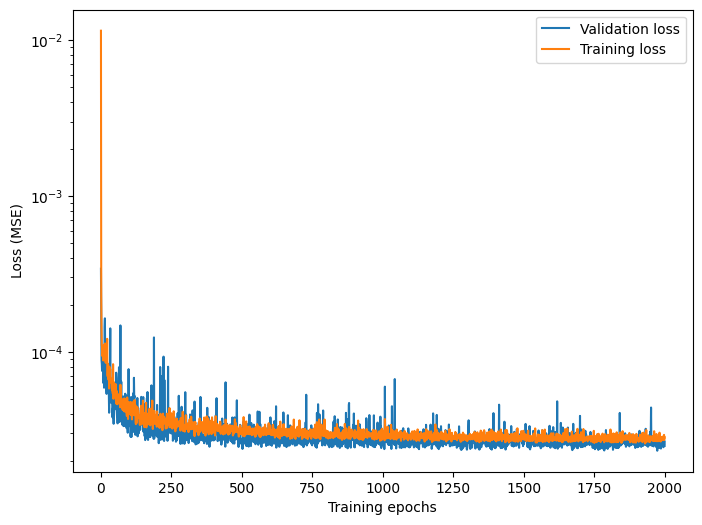

In [52]:
plt.figure(figsize=(8,6))
history.history.keys()
plt.semilogy(history.history['val_loss'])
plt.semilogy(history.history['loss'])
plt.legend(['Validation loss', 'Training loss'])
plt.xlabel('Training epochs')
plt.ylabel('Loss (MSE)')
#plt.savefig(f'./NNresults/Loss/icpGenerated256x8.jpg', dpi=300)
plt.show()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)
pd.DataFrame(history.history).loc[(pd.DataFrame(history.history)['val_loss'] == pd.DataFrame(history.history)['val_loss'].min()) | 
                                    (pd.DataFrame(history.history)['loss'] == pd.DataFrame(history.history)['loss'].min())]

### Network prediction and validation of results

In [38]:
y_predict = model.predict(x_test)
y_pred = pd.DataFrame(y_predict, columns=y_test.columns)

625/625 [==============================] - 2s 2ms/step


In [40]:
r2_dict = {}
for col in y_pred.columns:
    sum_squares_residuals = sum((y_test[col] - y_pred[col]) ** 2)
    sum_squares = sum((y_test[col] - y_test[col].mean()) ** 2)
    R2 = 1 - sum_squares_residuals / sum_squares
    r2_dict[col] = R2
r2_dict

{'t_C': 0.999981094676589,
 't_Ca': 0.9999901335828372,
 't_Si': 0.9999841625721745,
 't_H': 0.9999907153750042,
 't_O': 0.9999902003193686,
 'd_Portlandite': 0.9296639520629228,
 'd_Cal': 0.9999625923673622,
 'd_Jennite': 0.9990775577029024,
 'water': 0.9999271266913919}

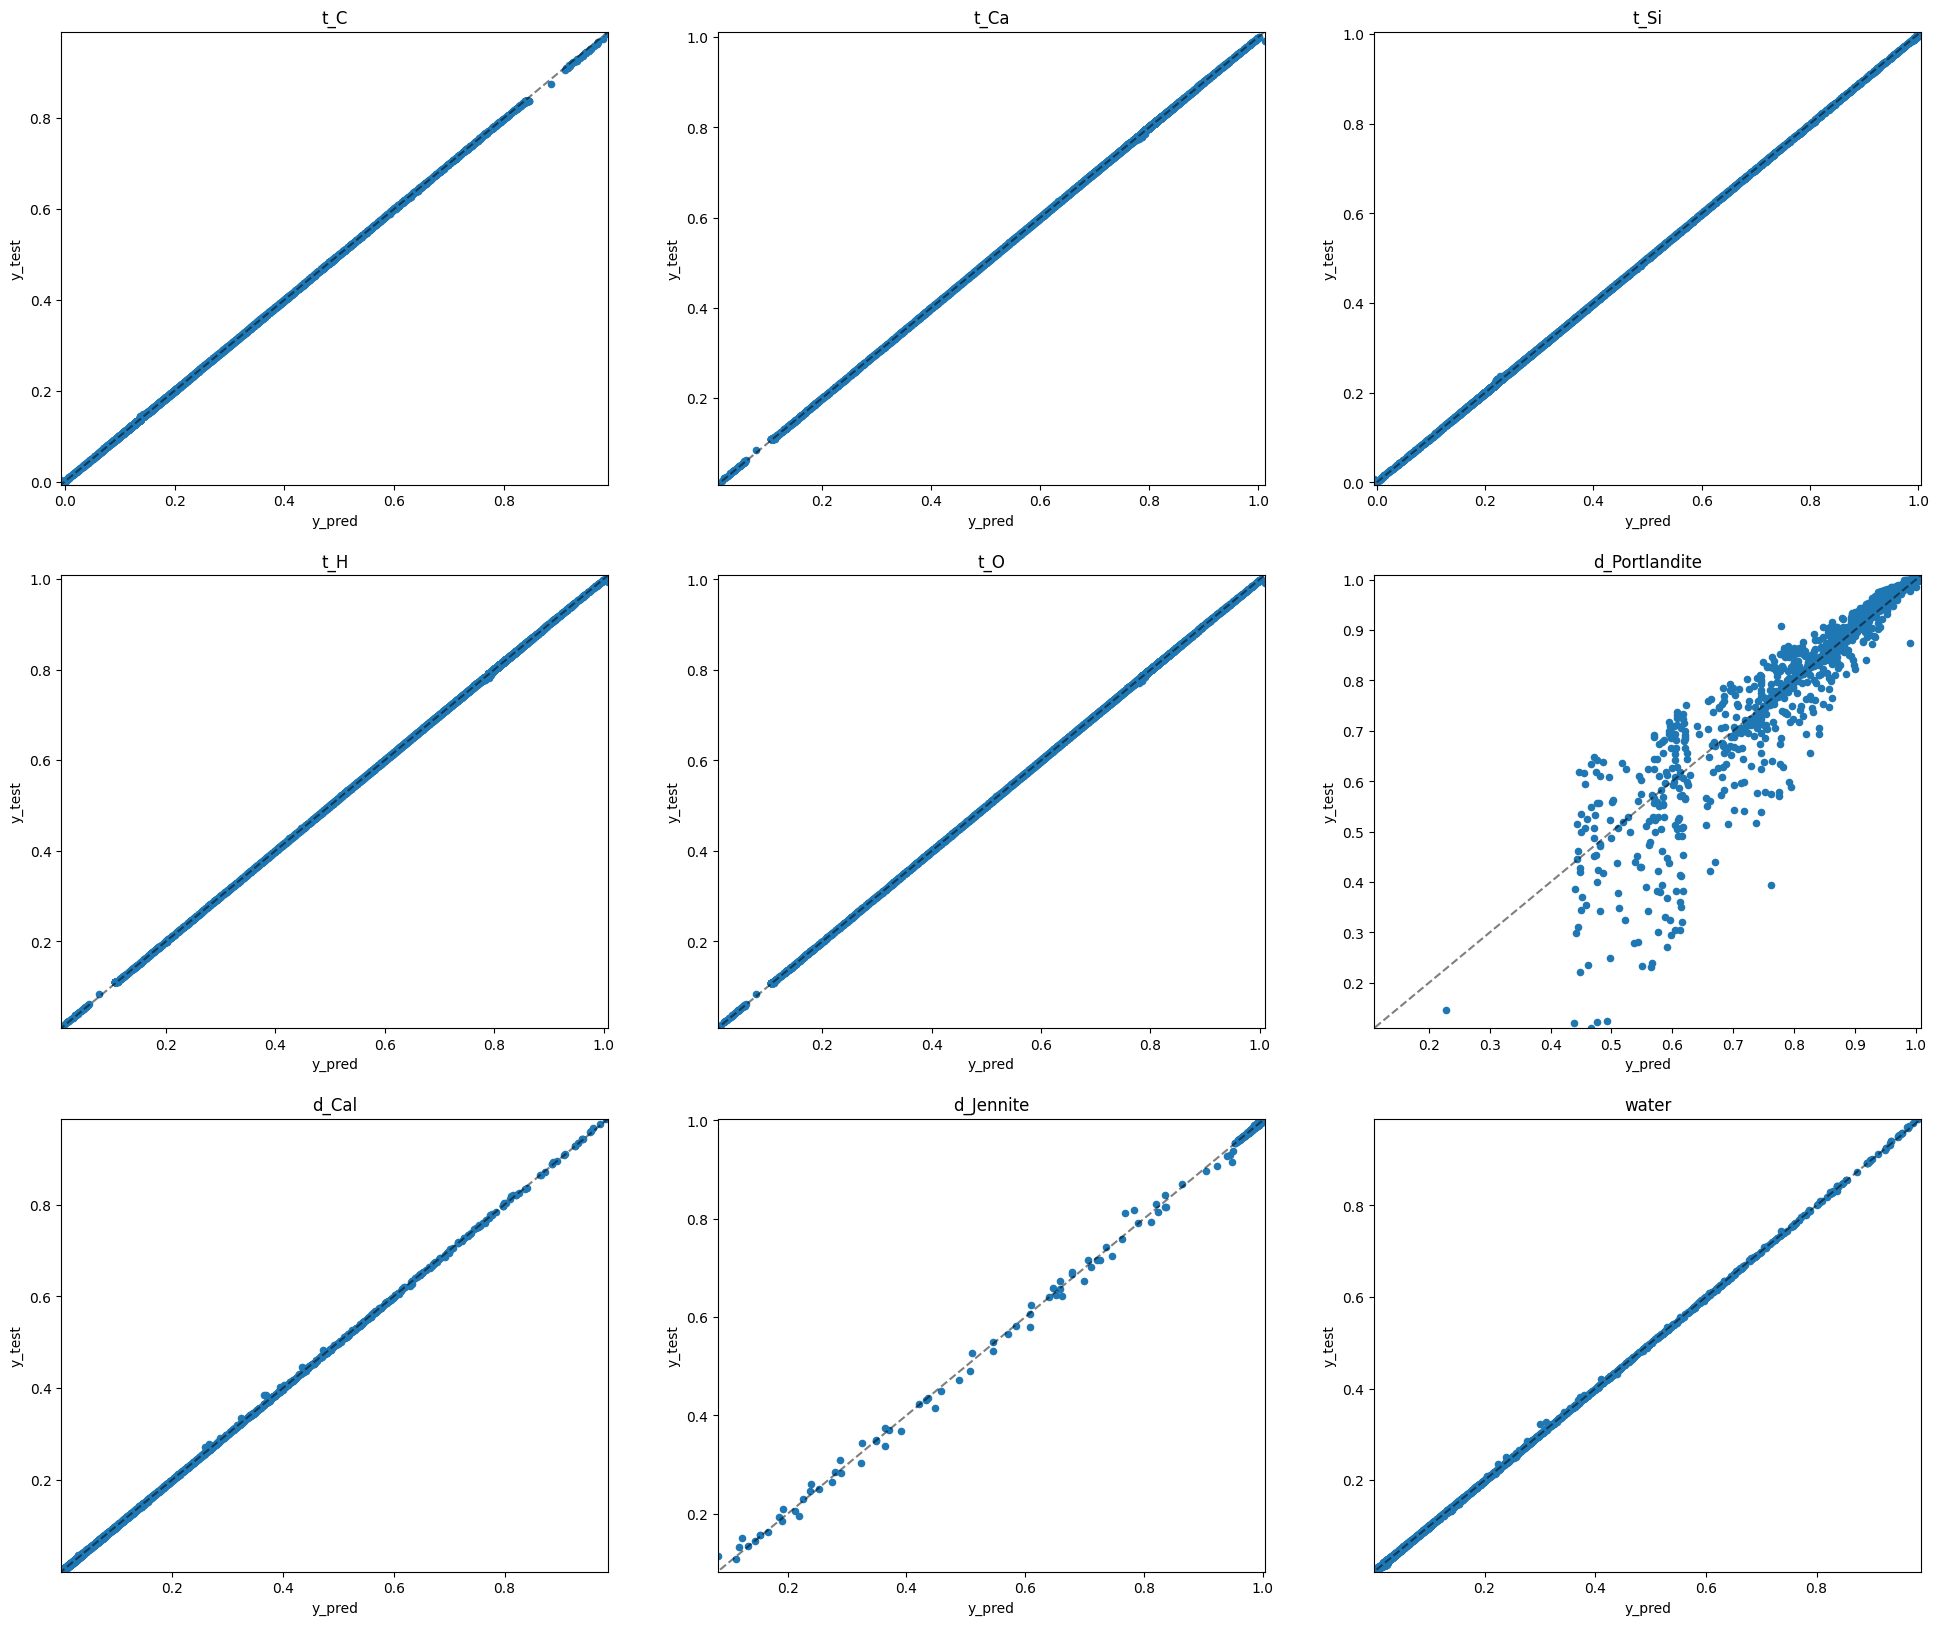

In [42]:
now = '-'.join('_'.join(datetime.now().strftime("%Y-%m-%d %H:%M:%S").split(' ')).split(':'))
r1 = np.linspace(-100,100,100)
fig, ax = plt.subplots(3,3, figsize=(24,20))
i = 0
for axs in ax.flat:
    if i<len(output_dataset.columns):
        col = output_dataset.columns[i]
        i+=1
        axs.scatter(y_pred[col], y_test[col], s=20)
        axs.plot(r1,r1,'k--',alpha=0.5)
        lim = [min(y_pred[col].min(), y_test[col].min()),max(y_pred[col].max(), y_test[col].max())]
        axs.set(xlabel='y_pred', ylabel='y_test', xlim=lim, ylim=lim)
        axs.set_title(col)
    else:
        pass
#plt.savefig(f'./NNresults/NNresults_RTM_{now}.jpg')

Features are rescaled back to their original values.

In [43]:
pred = pd.concat([x_test, y_pred], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train = pd.concat([x_train, y_train], axis=1)

In [44]:
train_reversed = scaler.inverse_transform(train)
train_reversed = pd.DataFrame(train_reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Cal', 'k_Jennite', 'waterMassFraction_coupling'])
pred_reversed = scaler.inverse_transform(pred)
pred_reversed = pd.DataFrame(pred_reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water'])
test_reversed = scaler.inverse_transform(test)
test_reversed = pd.DataFrame(test_reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','d_Portlandite', 'd_Cal', 'd_Jennite', 'water'])

for col in pred_reversed:
    if '_tr' in col:
        pred_reversed[col] = np.exp(pred_reversed[col]) - 1e-10# - data[col].min())
        test_reversed[col] = np.exp(test_reversed[col]) - 1e-10# - data[col].min())
    elif 't_' in col:
        pred_reversed[col] = np.exp(pred_reversed[col]) - 1e-10# - data[col].min())
        test_reversed[col] = np.exp(test_reversed[col]) - 1e-10# - data[col].min())

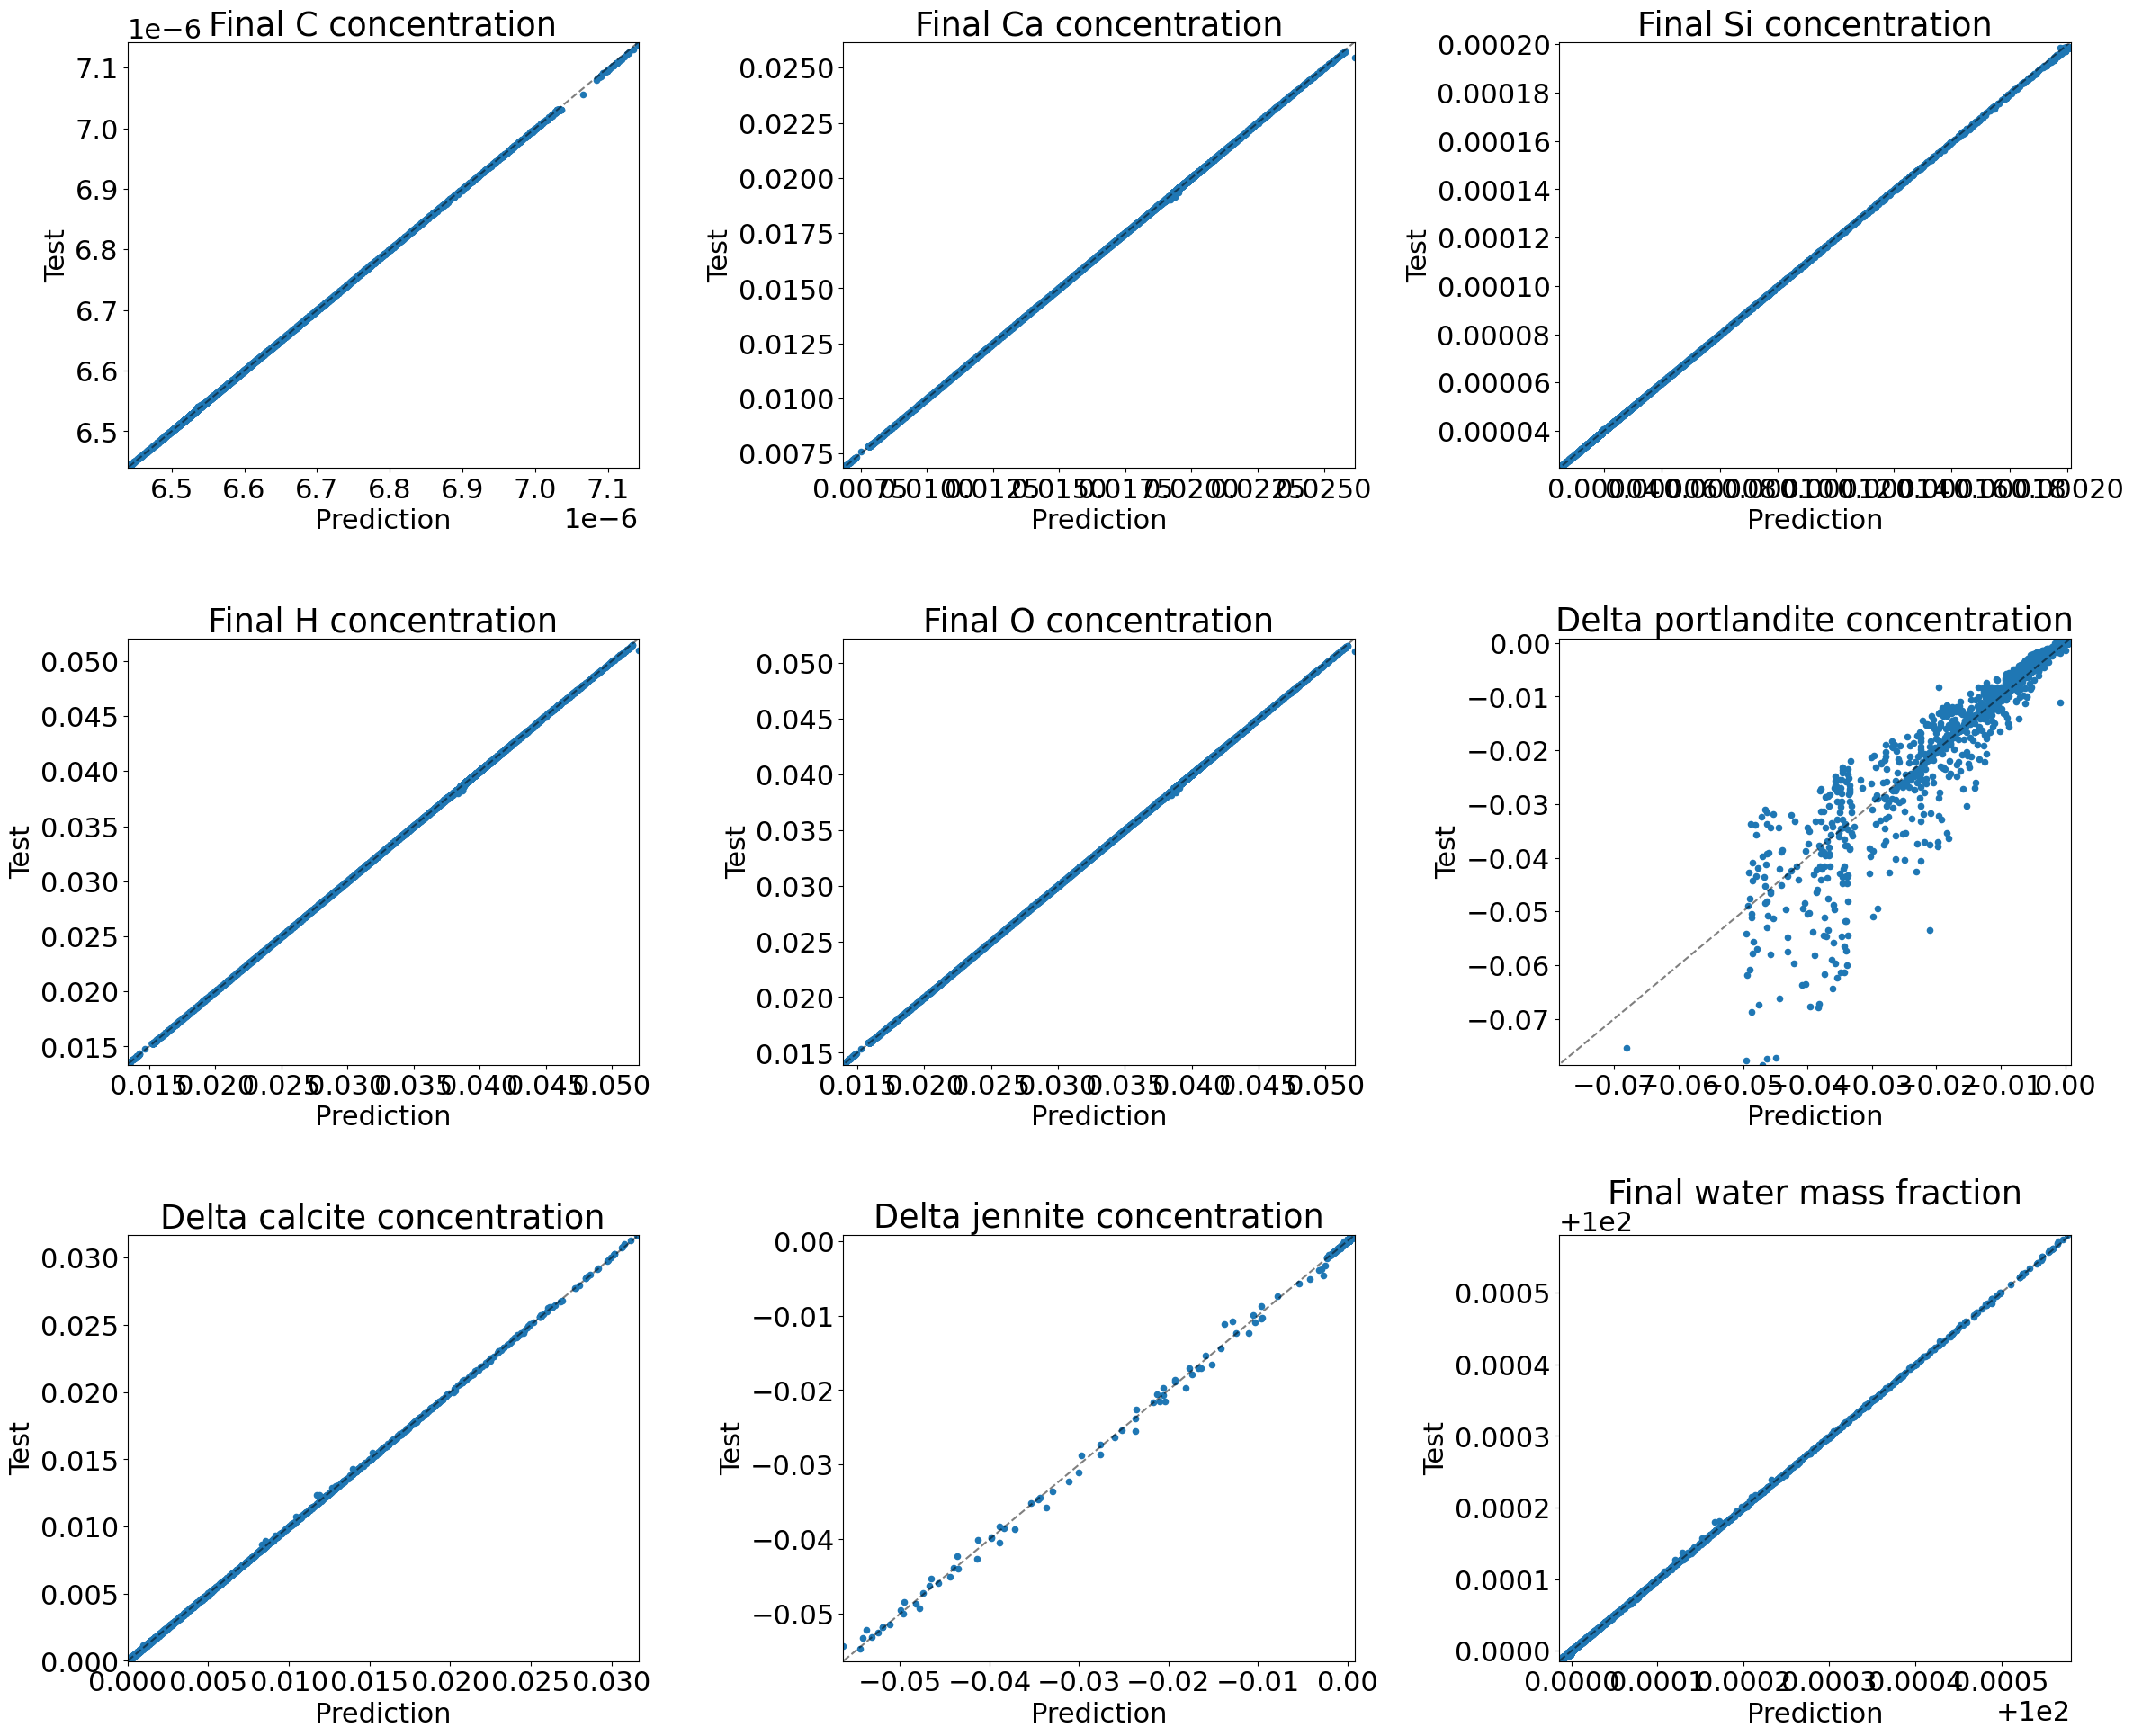

In [13]:
titles = ['Final C concentration', 'Final Ca concentration', 'Final Si concentration', 'Final H concentration', 'Final O concentration',
         'Delta portlandite concentration', 'Delta calcite concentration', 'Delta jennite concentration', 'Final water mass fraction']
plt.rcParams.update({'font.size': 22})
now = '-'.join('_'.join(datetime.now().strftime("%Y-%m-%d %H:%M:%S").split(' ')).split(':'))
r1 = np.linspace(-1000,1000,100)
fig, ax = plt.subplots(3,3, figsize=(24,20))
i = 0
outputs = ['t_C', 't_Ca', 't_Si', 't_H', 't_O', 'd_Portlandite', 'd_Cal', 'd_Jennite', 'water']
for axs in ax.flat:
    if i<len(output_dataset.columns):
        col = outputs[i]
        i+=1
        axs.scatter(pred_reversed[col], test_reversed[col], s=20)
        axs.plot(r1,r1,'k--',alpha=0.5)
        lim = [min(pred_reversed[col].min(), test_reversed[col].min()),max(pred_reversed[col].max(), test_reversed[col].max())]
        axs.set(xlabel='Prediction', ylabel='Test', xlim=lim, ylim=lim)
        axs.set_title(titles[i-1])
    else:
        pass
    plt.subplots_adjust(left=0.075, right=0.975, 
                    top=0.95, bottom=0.05, 
                    wspace=0.4, hspace=0.4)
#plt.savefig(f'./NNresults/NNresults_RTM_{now}.jpg', dpi=300)
plt.rcParams.update({'font.size': 10})

In [46]:
r2_dict_reversed = {}
for col in y_pred.columns:
    sum_squares_residuals = sum((test_reversed[col] - pred_reversed[col]) ** 2)
    sum_squares = sum((test_reversed[col] - test_reversed[col].mean()) ** 2)
    R2 = 1 - sum_squares_residuals / sum_squares
    r2_dict_reversed[col] = R2
r2_dict_reversed

{'t_C': 0.9999804783456637,
 't_Ca': 0.9999846931966608,
 't_Si': 0.9999644869506428,
 't_H': 0.9999856917806973,
 't_O': 0.9999853332434014,
 'd_Portlandite': 0.9296639520629081,
 'd_Cal': 0.9999625923673622,
 'd_Jennite': 0.9990775577029024,
 'water': 0.9999271266914292}